# Downloading packages

In [1]:
!pip install pandas numpy tqdm nltk transformers torch datasketch matplotlib contractions --q


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import json
from collections import Counter
import scipy
import re
import unicodedata
import contractions 
from nltk.tokenize import word_tokenize, TreebankWordDetokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from datasketch import MinHash, MinHashLSH
import matplotlib.pyplot as plt
from tqdm import tqdm  

# Loading Data

In [3]:
# Use tqdm for tracking the reading process
with tqdm(total=3, desc="Loading Data") as pbar:
    with open('Data/ids.txt', 'r') as f:
        ids = f.read().splitlines()
    pbar.update(1)

    with open('Data/texts.txt', 'r', encoding='utf-8') as f:
        texts = f.readlines()
    pbar.update(1)

    with open('Data/items.json', 'r') as file:
        ground_truth = json.load(file)
    pbar.update(1)

Loading Data: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


In [4]:
print(f"ids shape: {len(ids)}")
print(f"texts shape: {len(texts)}")
print(f"ground_truth shape: {len(ground_truth)}")

ids shape: 148928
texts shape: 148928
ground_truth shape: 148928


# Preprocess text

In [5]:
# Initialize the lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def expand_contractions(text):
    try:
        if not text:
            return ""
        
        text = text.replace('"', '"').replace('"', '"')
        text = text.replace(''', "'").replace(''', "'")
        
        expanded_text = contractions.fix(text)
        
        custom_contractions = {
            "ain't": "is not", "can't": "cannot", "won't": "will not", "don't": "do not", "doesn't": "does not",
            "didn't": "did not", "isn't": "is not", "aren't": "are not", "wasn't": "was not", "weren't": "were not",
            "he's": "he is", "she's": "she is", "it's": "it is", "they're": "they are", "I'm": "I am",
            "you're": "you are", "I've": "I have", "we've": "we have", "they've": "they have", "let's": "let us"
        }
        
        for contraction, expansion in custom_contractions.items():
            expanded_text = re.sub(
                rf'\b{contraction}\b',
                expansion,
                expanded_text,
                flags=re.IGNORECASE
            )
        
        return expanded_text
    except Exception as e:
        print(f"Error in expand_contractions: {str(e)}")
        return text

def preprocess_text(text, min_freq=2, min_length=3, custom_stop_words=None):
    try:
        if not text:
            return ""
        
        text = str(text)
        text = unicodedata.normalize('NFKC', text)
        text = text.lower()
        text = expand_contractions(text)
        text = re.sub(r'(http[s]?://|ftp://|www\.)\S+', '', text, flags=re.MULTILINE | re.IGNORECASE)
        text = re.sub(r'\S+@\S+', '', text)
        text = re.sub(r'<[^>]+>', '', text)
        text = re.sub(r'[^\w\s.,!?]', ' ', text)
        text = re.sub(r'\b\d+\b', '', text)
        text = ' '.join(text.split())
        tokens = word_tokenize(text)
        stop_words_set = set(stopwords.words('english'))
        if custom_stop_words:
            stop_words_set.update(custom_stop_words)
        
        lemmatizer = WordNetLemmatizer()
        processed_tokens = []
        for token in tokens:
            if (len(token) >= min_length and 
                token not in stop_words_set and 
                not token.isnumeric() and  
                not all(c in '.,!?' for c in token)): 
                
                lemmatized = lemmatizer.lemmatize(token)
                processed_tokens.append(lemmatized)
        
        if processed_tokens:
            frequency = Counter(processed_tokens)
            processed_tokens = [token for token in processed_tokens 
                              if frequency[token] >= min_freq]
        
        if processed_tokens:
            cleaned_text = TreebankWordDetokenizer().detokenize(processed_tokens)
        else:
            cleaned_text = ""
        
        return cleaned_text.strip()
    
    except Exception as e:
        print(f"Error in preprocess_text: {str(e)}")
        return ""

texts = [preprocess_text(text) for text in tqdm(texts, desc="Preprocessing Texts")]

Preprocessing Texts: 100%|██████████| 148928/148928 [10:23<00:00, 238.84it/s]


In [6]:
print(f"Texts Shape: {len(texts)}")

Texts Shape: 148928


# Embeddings Matrix

In [7]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=50000)
embedding_matrix = vectorizer.fit_transform(tqdm(texts, desc="Vectorizing Texts"))

Vectorizing Texts: 100%|██████████| 148928/148928 [00:06<00:00, 21783.81it/s]


In [8]:
print(f"Embedding Matrix Shape: {embedding_matrix.shape}")

Embedding Matrix Shape: (148928, 50000)


# Creating Minhash Signatures

In [9]:
lsh = MinHashLSH(threshold=0.35, num_perm=64)

def get_minhash(text_vector, num_perm=64):
    m = MinHash(num_perm=num_perm)
    for idx in text_vector.nonzero()[1]:
        m.update(str(idx).encode('utf8'))
    return m

minhashes = {}
for idx, (text_id, vector) in tqdm(enumerate(zip(ids, embedding_matrix)), total=len(ids), desc="Creating MinHashes"):
    minhash = get_minhash(vector)
    minhashes[text_id] = minhash
    lsh.insert(text_id, minhash)

Creating MinHashes:   0%|          | 0/148928 [00:00<?, ?it/s]

Creating MinHashes: 100%|██████████| 148928/148928 [03:30<00:00, 706.71it/s]


In [10]:
print(f"Minhashes Shape: {len(minhashes)}")

Minhashes Shape: 148928


# Predictions using LSH

In [14]:
id_to_index = {text_id: idx for idx, text_id in enumerate(ids)}

In [16]:
def cosine_similarity(v1, v2):
    if scipy.sparse.issparse(v1):
        v1 = v1.toarray().flatten()
    if scipy.sparse.issparse(v2):
        v2 = v2.toarray()
    return np.dot(v1, v2.T) / (np.linalg.norm(v1) * np.linalg.norm(v2, axis=1))

predicted_map = {}
for text_id in tqdm(ids, desc="Generating Predicted Hash Map"):
    minhash = minhashes[text_id]
    candidates = lsh.query(minhash)
    if candidates:  
        text_idx = id_to_index[text_id]
        candidate_indices = [id_to_index[c] for c in candidates]
        text_embedding = embedding_matrix[text_idx]
        candidate_embeddings = embedding_matrix[candidate_indices]
        similarities = cosine_similarity(text_embedding, candidate_embeddings).flatten()
        sorted_indices = similarities.argsort()[::-1]
        top_5 = [candidates[i] for i in sorted_indices[:5]]
        predicted_map[text_id] = top_5

with open('Outputs/predicted_map.json', 'w') as file:
    json.dump(predicted_map, file)

Generating Predicted Hash Map:   0%|          | 102/148928 [00:03<1:32:01, 26.95it/s]C:\Users\garvm\AppData\Local\Temp\ipykernel_3092\148729106.py:7: RuntimeWarning: invalid value encountered in divide
  return np.dot(v1, v2.T) / (np.linalg.norm(v1) * np.linalg.norm(v2, axis=1))
Generating Predicted Hash Map: 100%|██████████| 148928/148928 [1:29:41<00:00, 27.68it/s]  


In [17]:
print(f"Predicted Map Shape: {len(predicted_map)}")

Predicted Map Shape: 148928


# Evaluation

Evaluating Intersection Scores: 100%|██████████| 148928/148928 [00:00<00:00, 196264.52it/s]


Average Intersection Score: 0.05393210141813494
       Intersection Score
count       148928.000000
mean             0.053932
std              0.241709
min              0.000000
25%              0.000000
50%              0.000000
75%              0.000000
max              4.000000


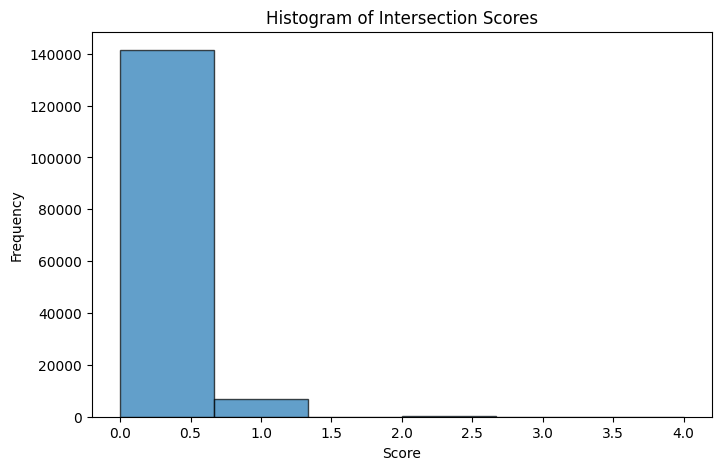

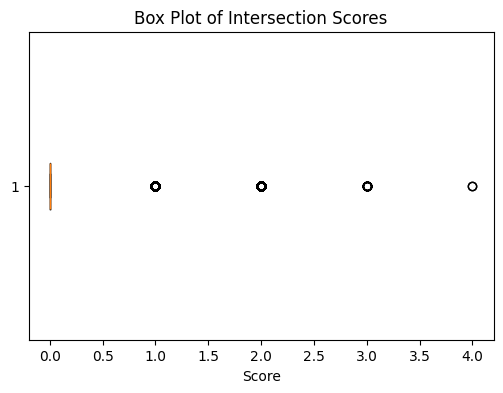

In [18]:
def intersection_score(predicted, ground_truth):
    return len(set(predicted) & set(ground_truth))

scores = []
for text_id in tqdm(ids, desc="Evaluating Intersection Scores"):
    ground_truth_items = ground_truth.get(text_id, [])
    predicted_items = predicted_map.get(text_id, [])
    score = intersection_score(predicted_items, ground_truth_items)
    scores.append(score)

average_score = np.mean(scores)
print(f'Average Intersection Score: {average_score}')

scores_df = pd.DataFrame(scores, columns=['Intersection Score'])
scores_df.to_csv('Outputs/scores.csv', index=False)

print(scores_df.describe())

with open('Outputs/scores_description.txt', 'w') as file:
    file.write(str(scores_df.describe()))

plt.figure(figsize=(8, 5))
plt.hist(scores, bins=6, edgecolor='black', alpha=0.7)
plt.title('Histogram of Intersection Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.savefig('Outputs/histogram.png')
plt.show()

plt.figure(figsize=(6, 4))
plt.boxplot(scores, vert=False)
plt.title('Box Plot of Intersection Scores')
plt.xlabel('Score')
plt.savefig('Outputs/boxplot.png')
plt.show()